In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import math
import random
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

from ipynb.fs.full.GenerateData import generatedata
from ipynb.fs.full.AnalysisPartFunctions import initialize_parameters,initialize_dicts,calc_prior_mean,calc_post_mean,calc_post_sd,calc_Phi,calc_L,calc_component_derivs,calc_gradients,update_parameters

In [2]:
random.seed(100)

**(a) Generate data**

In [3]:
data = pd.DataFrame(generatedata())

In [4]:
data.head()

,index,id,name,first,last,sex,race,dob,age,age_cat,...,r_charge_desc,r_jail_in,r_jail_out,is_violent_recid,num_vr_cases,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,release
0,0,1,miguel hernandez,miguel,hernandez,Male,Other,1947-04-18 00:00:00.000000,69,Greater than 45,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1
1,1,2,michael ryan,michael,ryan,Male,Caucasian,1985-02-06 00:00:00.000000,31,25 - 45,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0
2,2,3,kevon dixon,kevon,dixon,Male,African-American,1982-01-22 00:00:00.000000,34,25 - 45,...,Felony Battery (Dom Strang),NaN,NaN,1,NaN,13009779CF10A,(F3),2013-07-05 00:00:00.000000,Felony Battery (Dom Strang),1
3,3,4,ed philo,ed,philo,Male,African-American,1991-05-14 00:00:00.000000,24,Less than 25,...,Driving Under The Influence,2013-06-16 09:05:47.000000,2013-06-16 07:18:55.000000,0,NaN,NaN,NaN,NaN,NaN,1
4,4,5,marcu brown,marcu,brown,Male,African-American,1993-01-21 00:00:00.000000,23,Less than 25,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0


check how many released/remanded

In [5]:
data.release.value_counts()

1    6715
0    5027
Name: release, dtype: int64

**(b) Create dummy variables for categorical variables**

In [6]:
sex_dummies = pd.get_dummies(data['sex'])
race_dummies = pd.get_dummies(data['race'])

data['sex_1_male'] = sex_dummies['Male']
data['African_American']=race_dummies['African-American']
data['Asian']=race_dummies['Asian']
data['Caucasian']=race_dummies['Caucasian']
data['Hispanic'] = race_dummies['Hispanic']
data['Native_American']=race_dummies['Native American']
data['Other']=race_dummies['Other']

**(c) Split data into training & test**

In [7]:
# select out relevant data & generate the train and test data

# train / test
X = data[['release','decile_score','age']].drop(['release'],axis=1)#,'is_violent_recid'
y = data['release']
class_names = data.release.unique()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=120)

risk_assess_train = X_train['decile_score']
X_train = X_train.drop(['decile_score'],axis=1)

risk_assess_test = X_test['decile_score']
X_test = X_test.drop(['decile_score'],axis=1)

Define variables for analysis without penalties

In [8]:
X = X_train['age'].tolist()
Y = y_train.tolist()
mu_ra = risk_assess_train.tolist()
theta = 5
num_int = 10
learning_rate = 0.0001

In [9]:
parameters = initialize_parameters(X_train,1,10)
#parameters = {
#    'B':0.023820856984315887,
#    'b': 5.404939356823157,
#    'q': 0.7178027471079145,
#    'sd_prior': 4.786505876750552,
#    'tau': 9
#}
derivatives,grads = initialize_dicts()

In [10]:
parameters

{'B': 0.015812910378652678,
 'b': 6.960580130229113,
 'q': 0.9259321407179847,
 'sd_prior': 4.532735652988392,
 'tau': 9}

In [11]:
loss = []
j = 0

while j < num_int:
    
    #var_prior = parameters['var_prior']
    #q = parameters['q']
    #tau = parameters['tau']
        
    mu_prior = calc_prior_mean(X, parameters)
    mu_post = calc_post_mean(mu_prior, mu_ra, parameters, theta)
    sd_post =calc_post_sd(mu_prior, mu_ra, parameters, theta)
    Phi = calc_Phi(mu_post, sd_post, parameters)
    L = calc_L(Phi, Y)
    loss.append(L)
        
    derivatives = calc_component_derivs(X,parameters, derivatives, theta, mu_prior,mu_ra,mu_post,sd_post,Phi,Y)
    grads = calc_gradients(X,grads,derivatives)
    parameters = update_parameters(parameters, grads, learning_rate)
       
    if j%1==0:
        print(L)
        #plt.plot(loss)
    j+=1
        


0.86224928422804
0.8622243479545831
0.8621994181004942
0.8621744946659577
0.8621495776511194
0.8621246670561357
0.8620997628812259
0.8620748651265343
0.8620499737922276
0.8620250888784606


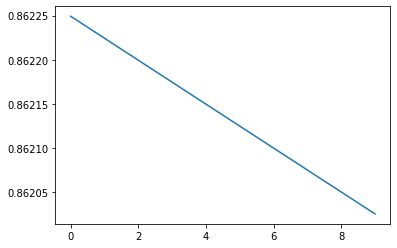

In [12]:
plt.plot(loss)

In [ ]:
mu_post

In [ ]:
plt.hist(mu_post)

In [ ]:
parameters

In [ ]:
plt.hist(mu_prior)

Define variables for analysis with penalties

In [ ]:
parameters = initialize_parameters(X_test,1,10)
derivatives,grads = initialize_dicts()

X = X_train
y = np.array(y_train)
mu_ra = np.array(risk_assess_train)
theta = 5
num_int = 100
learning_rate = 0.001
k = 1

In [ ]:
parameters

In [ ]:
loss = []
j = 0

while j < num_int:
    
    var_prior = parameters['var_prior'][0]
    q = parameters['q'][0]
    tau = parameters['tau']
        
    mu_prior = calc_prior_mean(X, parameters)[0]
    mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
    var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
    Phi = calc_Phi(mu_post, var_post, tau)
    L = calc_L(Phi, y, mu_prior, k)
    loss.append(np.sum(L))
        
    if j%%5==0:
        print(L)
        
    derivatives = calc_component_derivs(X, y, parameters, derivatives, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
    grads = calc_gradients(grads, derivatives, mu_prior, X)
    parameters = update_parameters(parameters, grads, learning_rate)
    
    j+=1
        


In [ ]:
loss

In [ ]:
loss = []

var_prior = parameters['var_prior'][0]
q = parameters['q'][0]
tau = parameters['tau']

mu_prior = calc_prior_mean(X, parameters)[0]
mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
Phi = calc_Phi(mu_post, var_post, tau)
L = calc_L(Phi, y, mu_prior, k)
loss.append(np.sum(L))
        
derivatives = calc_component_derivs(X, y, parameters, derivatives, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
grads = calc_gradients(grads, derivatives, mu_prior, X)
parameters = update_parameters(parameters, grads, learning_rate)

In [ ]:
print("B: ",parameters['B'])
print("b: ",parameters['b'])
print("q: ",parameters['q'])
print("var_prior: ",parameters['var_prior'])
print("tau: ",parameters['tau'])
print("loss: ",loss)
print("mu_prior: ",np.min(mu_prior),"to",np.max(mu_prior))
print("mu_post: ",np.min(mu_post),"to",np.max(mu_post))
print("Phi: ", np.min(Phi),"to",np.max(Phi))

In [ ]:
parameters

In [ ]:
var_prior = parameters['var_prior'][0]
q = parameters['q'][0]
tau = parameters['tau']

In [ ]:
mu_prior = calc_prior_mean(X, parameters)[0]
mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
Phi = calc_Phi(mu_post, var_post, tau)
L = calc_L(Phi, y, mu_prior, k)

In [ ]:
mu_prior

In [ ]:
test1 = 10*((1-mu_prior)**3)
test2 = y_train*np.log(1-Phi)+(1-y)*np.log(Phi)
test = test1 + test2
test

In [ ]:
loss.append(np.sum(L))
        
derivatives = calc_component_derivs(X, y, parameters, derivatives, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
grads = calc_gradients(grads, derivatives, mu_prior, X)
parameters = update_parameters(parameters, grads, learning_rate)

In [ ]:
parameters

In [ ]:
derivatives

In [ ]:
"""
# Predict test/train set examples 
#y_pred_train = predict(parameters,X_train,y_train,risk_assess_train,theta=5)
#y_pred_test = predict(parameters,X_test,y_test,risk_assess_test,theta=5)

# Print train/test Errors
# general accuracy
print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

# confusion matrix
confmat = []

for true,pred in zip(y_train,y_pred_train):
    if(true==1 and pred==1):
        confmat.append("tp")
    elif(true==1 and pred==0):
        confmat.append("fn")
    elif(true==0 and pred==0):
        confmat.append("tn")
    else:
        confmat.append(fp)

print("true positives: ",confmat.count('tp'))
print("false positives: ",confmat.count('fp'))
print("true negatives: ",confmat.count('tn'))
print("false negatives: ",confmat.count('fn'))

if (confmat.count('tp')+confmat.count('fn'))>0:
    print("sensitivity/recall: ",confmat.count('tp')/(confmat.count('tp')+confmat.count('fn')))
else:
    print("sensitivity/recall: N/A")
    
if (confmat.count('tn')+confmat.count('fp'))>0:
    print("specificity: ",confmat.count('tn')/(confmat.count('tn')+confmat.count('fp')))
else:
    print("specificity: N/A")
    
if (confmat.count('tp')+confmat.count('fp'))>0:
    print("precision: ",confmat.count('tp')/(confmat.count('tp')+confmat.count('fp')))
else:
    print("precision: N/A")
    
model_dict = {"nLL": L,
              "y_pred_test": y_pred_test,
              "y_pred_train" : y_pred_train,
              "parameters" : parameters
              "learning_rate" : learning_rate,
              "num_iterations": num_iterations}

#return model_dict
"""

In [ ]:
def training_model(X,y,parameters,mu_ra,theta,num_int,learning_rate,k):
    
    mu_ra = np.array(mu_ra)
    y=np.array(y)
    loss = []
    j = 0
    
    while j < num_int:
        
        var_prior = parameters['var_prior'][0]
        q = parameters['q'][0]
        tau = parameters['tau']
        
        mu_prior = calc_prior_mean(X, parameters)[0]
        mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
        var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
        Phi = calc_Phi(mu_post, var_post, tau)
        L = calc_L(Phi, y, mu_prior, k)
        loss.append(np.sum(L))
        
        derivatives = calc_component_derivs(X, parameters, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
        grads = calc_gradients(derivatives, mu_prior, X)
        parameters = update_parameters(parameters, grads, learning_rate)
        #print(parameters)
        j+=1
        
    return loss, parameters, derivatives, grads

In [ ]:
def predict(parameters,X,y,risk_assess,theta):
    
    tau = parameters['tau']
    q = parameters['q']
    mu_ra = np.array(risk_assess)
    mu_prior = calc_prior_mean(X,parameters)[0]
    var_prior = parameters['var_prior']
    #var_ra = calc_var_ra(var_prior,mu_prior,mu_ra,q,theta)
    
    mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
    var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
    Phi = calc_Phi(mu_post,var_post,tau)
    #L = calc_L(Phi,y)
    
    y_pred = [1 if Phi[i]>0.5 else 0 for i in range(len(Phi))]
    
    return y_pred